In [1]:
import numpy as np
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

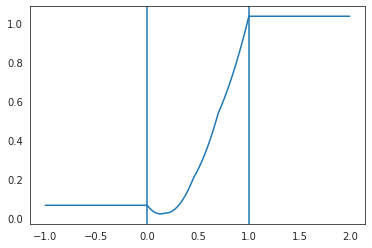

In [19]:
N = 10
thetas = np.arange(-1, 2, 0.01)
q = 0.2
f_N = np.random.randn(N)
f_N = np.minimum(f_N, 1)
f_N = np.maximum(f_N, 0)

def pinball_loss(f_N, theta, q):
    diff_N = f_N - theta
    l_N = q * diff_N
    l_N[diff_N < 0] = (1 - q) * -diff_N[diff_N < 0]
    return l_N

def ss(f_N, theta, q):
    l_N = pinball_loss(f_N, theta, q)
    lhat = np.mean(l_N)
    return np.sum(np.square(l_N - lhat))

ss_theta = np.array([ss(f_N, th, q) for th in thetas])
plt.plot(thetas, ss_theta);
plt.axvline(np.min(f_N))
plt.axvline(np.max(f_N))